In [1]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image as Image

In [2]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #pre-trained model accepts (224,224,3) image

In [3]:
imS = (224,224)
C = tf.keras.Sequential([
    hub.KerasLayer(classifier_url,input_shape=imS+(3,))
])

2023-04-17 13:14:37.044322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 13:14:37.297063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 13:14:37.297163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 13:14:37.307616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-17 13:14:37.307943: I tensorflow/compile

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


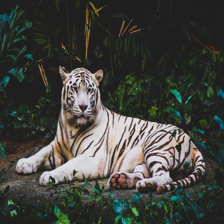

In [4]:
I = Image.open(r'/home/rahul/WSL_Projects/ReferencesPython/Convolutional Neural Networks/TransferLearningTF/tiger.jpg').resize(imS)
I

In [5]:
I = np.array(I)/255.0
I.shape

(224, 224, 3)

In [6]:
r = C.predict(I[np.newaxis,...])
r.shape #none of the classes is 1001

2023-04-17 13:22:58.328511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


1/1 [==============================] - 8s 8s/step


(1, 1001)

In [7]:
pc = np.argmax(r[0],axis=-1)
pc #predicted class

293

In [8]:
#get image labels based on the classes available
lp = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imnet_labels = np.array(open(lp).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


Text(0.5, 1.0, 'tiger')

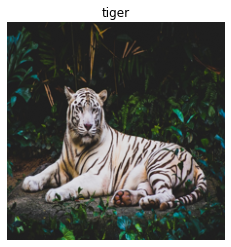

In [9]:
plt.imshow(I)
plt.axis('off')
pcn = imnet_labels[pc]
plt.title(pcn) #the classification was correct

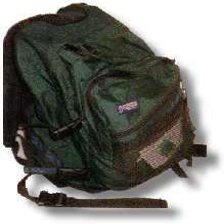

In [10]:
I = Image.open(r'/home/rahul/WSL_Projects/ReferencesPython/Convolutional Neural Networks/TransferLearningTF/Calteck_DataSet_256_ObjectCategories/003.backpack/003_0003.jpg').resize(imS)
I

In [11]:
I = np.array(I)/255.0
I.shape

(224, 224, 3)

In [12]:
r = C.predict(I[np.newaxis,...])
r.shape

1/1 [==============================] - 0s 44ms/step


(1, 1001)

In [13]:
pc = np.argmax(r[0],axis=-1)
pc

415

Text(0.5, 1.0, 'backpack')

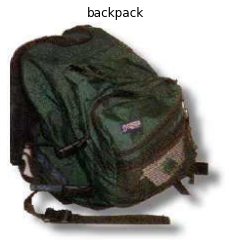

In [14]:
plt.imshow(I)
plt.axis('off')
pcn = imnet_labels[pc]
plt.title(pcn)

## Lets use transfer learning on the model

In [15]:
data_root = tf.keras.utils.get_file(
'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
untar=True)

228813984/228813984 [==============================] - 10s 0us/step


In [16]:
ig = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
imData = ig.flow_from_directory(str(data_root),target_size=imS)

Found 3670 images belonging to 5 classes.


In [17]:
for imB,lbB in imData:
    print(imB.shape) #32 images per batch 224x224x3
    print(lbB.shape) #32 images has 5 classes
    break

(32, 224, 224, 3)
(32, 5)


In [18]:
rB = C.predict(imB)
rB.shape

1/1 [==============================] - 2s 2s/step


(32, 1001)

In [20]:
pcn = imnet_labels[np.argmax(rB,axis=-1)] #predicted class names
pcn

array(['daisy', 'pot', 'artichoke', 'daisy', 'lawn mower', 'sea urchin',
       'bee', 'daisy', 'daisy', 'daisy', 'picket fence',
       "yellow lady's slipper", 'mushroom', 'barn spider', 'cardoon',
       'daisy', 'handkerchief', 'daisy', 'daisy', 'picket fence', 'daisy',
       'daisy', 'picket fence', 'bee', 'mushroom', 'daisy', 'daisy',
       'porcupine', 'daisy', 'daisy', 'confectionery', 'daisy'],
      dtype='<U30')

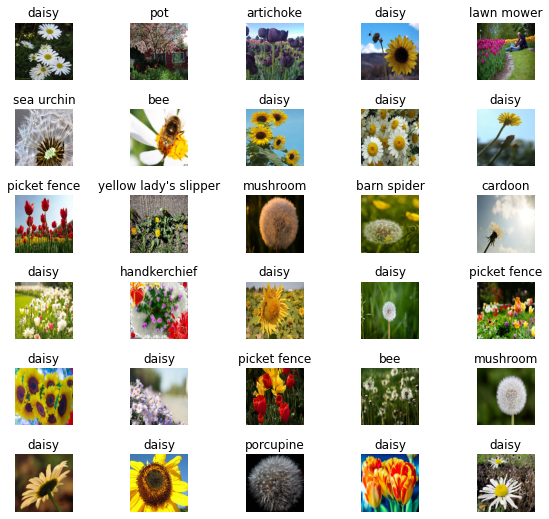

In [21]:
#label images with current model predictions
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(imB[i])
    plt.title(pcn[i])
    plt.axis('off')

In [22]:
# classifier without head
headLessModel_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'

In [23]:
headLessModel = hub.KerasLayer(headLessModel_url,input_shape=imS+(3,))

In [24]:
fImB = headLessModel(imB) #feature extractor
fImB.shape

TensorShape([32, 1280])

In [25]:
headLessModel.trainable = False #freeze the weights

In [26]:
newModel = tf.keras.Sequential([
    headLessModel,
    tf.keras.layers.Dense(imData.num_classes,activation='softmax')#5 classes
])

In [27]:
newModel.compile(
optimizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
metrics=['acc'])

In [28]:
newModel.fit(imData,epochs=10) #train with our own model

Epoch 1/10


/usr/lib/python3/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-04-17 15:22:48.498069: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f84bc0205b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-17 15:22:48.498710: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2023-04-17 15:22:48.779649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/115 [..............................] - ETA: 14:49 - loss: 2.1747 - acc: 0.1875

2023-04-17 15:22:49.757921: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 [==============================] - 20s 106ms/step - loss: 0.6817 - acc: 0.7477
Epoch 2/10
115/115 [==============================] - 10s 88ms/step - loss: 0.3377 - acc: 0.8877
Epoch 3/10
115/115 [==============================] - 9s 79ms/step - loss: 0.2696 - acc: 0.9144
Epoch 4/10
115/115 [==============================] - 10s 82ms/step - loss: 0.2266 - acc: 0.9267
Epoch 5/10
115/115 [==============================] - 10s 85ms/step - loss: 0.1945 - acc: 0.9398
Epoch 6/10
115/115 [==============================] - 10s 85ms/step - loss: 0.1708 - acc: 0.9507
Epoch 7/10
115/115 [==============================] - 10s 80ms/step - loss: 0.1511 - acc: 0.9613
Epoch 8/10
115/115 [==============================] - 10s 85ms/step - loss: 0.1356 - acc: 0.9635
Epoch 9/10
115/115 [==============================] - 11s 96ms/step - loss: 0.1231 - acc: 0.9689
Epoch 10/10
115/115 [==============================] - 11s 91ms/step - loss: 0.1121 - acc: 0.9757


In [29]:
cn = np.array(['Daisy','Dandelion','Roses','Sunflowers','Tulips'])

In [30]:
p = newModel.predict(imB)
p_ids = np.argmax(p,axis=-1)
pcn = cn[p_ids]

1/1 [==============================] - 1s 552ms/step


In [31]:
l_ids = np.argmax(lbB,axis=-1)

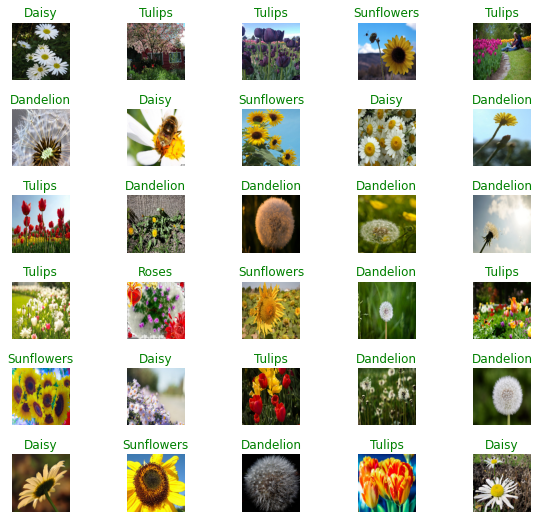

In [35]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.imshow(imB[i])
    color = 'green' if p_ids[i] == l_ids[i] else 'red'
    plt.title(pcn[i].title(),color=color)
    plt.axis('off')

### We did not follow the original frlow of Machine Learning here to keep things simple but we should still do testing for losses and validations